## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [3]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [4]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

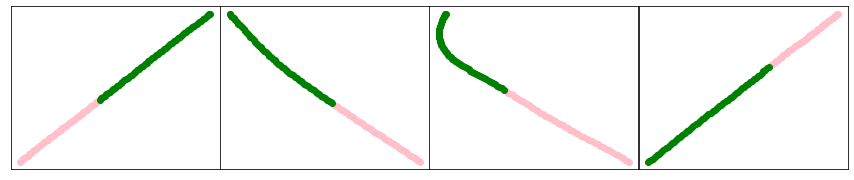

In [18]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1], color='pink')
        axs[i].scatter(out[i,:,0], out[i,:,1], color='green')

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

### the distribution of input/output positions for all agents

In [73]:
#get all cities
cities = ['austin', 'dearborn', 'miami', 'palo-alto', 'pittsburgh', 'washington-dc']

all_inputs = []
all_outputs = []

def get_data(city, split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    for i in inputs.tolist():
        all_inputs.append(i)
    
    f_out = ROOT_PATH + split + "/" + city + "_outputs"
    outputs = pickle.load(open(f_out, "rb"))
    for i in outputs.tolist():
        all_outputs.append(i)
    

for city in cities:
    get_data(city)

In [76]:
#convert to array
inputs_array = np.asarray(all_inputs)
outputs_array = np.asarray(all_outputs)

In [79]:
#reshape so that its one dim for all cities
n, t, d = inputs_array.shape
allTimes_inputs_array = inputs_array.reshape(n*t, d)

In [81]:
n, t, d = outputs_array.shape
allTimes_outputs_array = outputs_array.reshape(n*t, d)

In [163]:
#put x and y in groups
import pandas as pd
df_input = pd.DataFrame(data=allTimes_inputs_array, columns=['x', 'y'])
df_input['x_groups'] = df_input.x // 100
df_input['y_groups'] = df_input.y // 100

In [190]:
df_output = pd.DataFrame(data=allTimes_outputs_array, columns=['x', 'y'])
df_output['x_groups'] = df_output.x // 100
df_output['y_groups'] = df_output.y // 100

In [173]:
#get the counts for each (x, y) group
df_input_new = df_input.groupby(['x_groups', 'y_groups']).size()
df_input_new = pd.DataFrame(df_input_new)

In [179]:
df_input_new.columns = ['counts']
df_input_new = df_input_new.reset_index()

In [191]:
df_output_new = df_output.groupby(['x_groups', 'y_groups']).size()
df_output_new = pd.DataFrame(df_output_new)
df_output_new.columns = ['counts']
df_output_new = df_output_new.reset_index()

In [186]:
#convert the groups back (*100)
df_input_new.x_groups = df_input_new.x_groups * 100
df_input_new.y_groups = df_input_new.y_groups * 100

In [192]:
df_output_new.x_groups = df_output_new.x_groups * 100
df_output_new.y_groups = df_output_new.y_groups * 100

In [193]:
#pivot
df_input_plot = df_input_new.pivot(index='x_groups', columns='y_groups', values='counts')
df_output_plot = df_output_new.pivot(index='x_groups', columns='y_groups', values='counts')

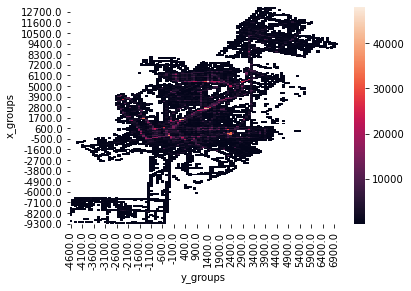

In [189]:
#heatmap for all input position
sns.heatmap(df_input_plot).invert_yaxis()

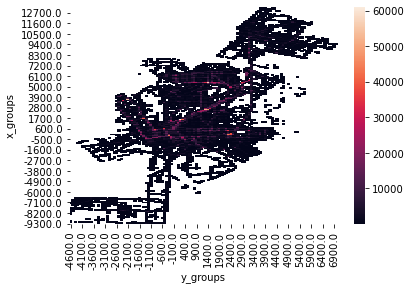

In [195]:
#heatmap for all output position
sns.heatmap(df_output_plot).invert_yaxis()

scatterplot of distributions

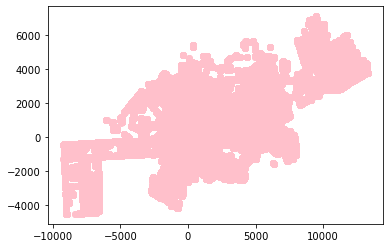

In [135]:
plt.scatter(df_input.x, df_input.y, color='pink') #input

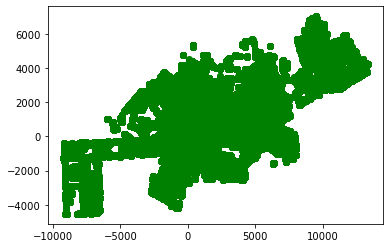

In [136]:
plt.scatter(df_output.x, df_output.y, color='green') #output